# `Итоговый проект. Анализ сайта образовательных курсов`

By Lidya Mitskovets

### Осуществим подготовку данных

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv - дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных 

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [1]:
# подключение библиотек 

import pandas as pd 
import pandahouse as ph
import requests
from urllib.parse import urlencode
import json
import matplotlib.pyplot as plt
from scipy.stats import norm, mannwhitneyu, chi2_contingency
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# счивание .csv файлов с Яндекс диска

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_groups = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'  
public_key_active_studs = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
public_key_checks = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

final_url_groups = base_url + urlencode(dict(public_key=public_key_groups))   # формирование url 
response_groups = requests.get(final_url_groups)   # запрос на извлечение данных по указанному url
download_url_groups = json.loads(response_groups.text)['href']   # парсинг данных 
groups = pd.read_csv(download_url_groups, sep=';')   # считывание данных в формате dataframe

final_url_active_studs = base_url + urlencode(dict(public_key=public_key_active_studs))
response_active_studs = requests.get(final_url_active_studs)
download_url_active_studs = json.loads(response_active_studs.text)['href']
active_studs = pd.read_csv(download_url_active_studs, sep=';')

final_url_checks = base_url + urlencode(dict(public_key=public_key_checks))
response_checks = requests.get(final_url_checks)
download_url_checks = json.loads(response_checks.text)['href']
checks = pd.read_csv(download_url_checks, sep=';')

In [3]:
# просмотр данных
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
# вывод общей информации о данных
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
# приведение к нужному типу данных
groups = groups.astype({'id': 'string', 'grp': 'string'})

In [6]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [7]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [8]:
active_studs = active_studs.astype({'student_id': 'string'})\
                           .rename(columns={'student_id': 'id'})

In [9]:
# данное сохранение понадобится для 3-го задания
active_studs_add = active_studs

In [10]:
# дополнение таблицы active_studs данными из таблицы groups
active_studs = active_studs.merge(groups, how='left', on='id')

In [11]:
active_studs.head()

,id,grp
0,581585,A
1,5723133,<NA>
2,3276743,B
3,4238589,A
4,4475369,B


In [12]:
active_studs.shape

(8341, 2)

In [13]:
# просмотр количества нулевых элементов в столбцах
active_studs.isna().sum()

id      0
grp    13
dtype: int64

In [14]:
# удаление id пользователей, которые не участвуют в эксперименте 
active_studs = active_studs.fillna("0").query('grp != "0"')

In [15]:
active_studs.shape

(8328, 2)

In [16]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [17]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [18]:
checks = checks.astype({'student_id': 'string'})\
               .rename(columns={'student_id': 'id'})

In [19]:
# данное сохранение понадобится для 3-го задания
checks_add = checks

In [20]:
checks = checks.merge(groups, how='left', on='id')

In [21]:
checks.isna().sum()

id     0
rev    0
grp    1
dtype: int64

In [22]:
# выявление пользователя, который не участвует в эксперименте 
checks.fillna("0").query('grp == "0"')

,id,rev,grp
540,5740903,1900.0,0


In [23]:
# удаление id пользователя, который не участвует в эксперименте 
checks = checks.fillna("0").query('grp != "0"')

In [24]:
checks.head()

,id,rev,grp
0,1627,990.0,A
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B


In [25]:
# проверка на совпадение множества активных пользователей в этот день и на покупающих пользователей.
# если запись пользователей верна, то разница будет 0
checks_id_list = checks.id.to_list()
active_studs_id_list = active_studs.id.to_list()
new_activ = list(set(checks_id_list) - set(active_studs_id_list))
len(new_activ)

149

In [26]:
type(new_activ[0])

str

Проверка выявила пользователей, которые купили курс в данный промежуток времени, но не были зафиксированны как посещающие сайт. Это говорит об **ошибке в программе записи пользователей, посещающих сайт**. Добавим эти id в список id активных пользователей.

In [27]:
active_studs.query('id in @new_activ')

,id,grp


In [28]:
active_studs_new = checks.query('id in @new_activ')
active_studs_new

,id,rev,grp
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
5,100645,630.0,B
6,102534,580.0,B
...,...,...,...
508,5291900,199.0,B
512,5331842,290.0,B
521,5486319,199.0,B
530,5562806,398.0,B


In [29]:
# добавление нового списка id
active_studs = active_studs.merge(active_studs_new.drop(columns=['rev']), how='outer', on=['id', 'grp'])

In [30]:
active_studs.shape

(8477, 2)

In [31]:
# проверка на пересечение контрольной и целевой группы у активных пользователей
active_studs_id_a = active_studs[active_studs.grp == "A"].id.to_list()
active_studs_id_b = active_studs[active_studs.grp == "B"].id.to_list()
a_b_activ = list(set(active_studs_id_a) & set(active_studs_id_b))
len(a_b_activ)

0

In [32]:
# проверка на пересечение контрольной и целевой группы у всех пользователей
groups_id_a = groups[groups.grp == "A"].id.to_list()
groups_id_b = groups[groups.grp == "B"].id.to_list()
a_b_groups = list(set(groups_id_a) & set(groups_id_b))
len(a_b_groups)

0

In [33]:
# проверка на пересечение контрольной и целевой группы у покупающих пользователей
checks_id_a = checks[checks.grp == "A"].id.to_list()
checks_id_b = checks[checks.grp == "B"].id.to_list()
a_b_checks = list(set(checks_id_a) & set(checks_id_b))
len(a_b_checks)

0

# `Задание №1. A/B-тестирование`

## A - контроль
## B - целевая группа

**Целью A/B тестирования** является увеличение прибыли и увеличение количества пользователей, покупающих курсы.

**Общая гипотеза** заключается в следующем: 
>"Если изменить механику оплаты услуг на сайте, то уменьшится часть пользователей, которые отваливаются на стадии покупки, что позитивно повлияет на монетизацию, потому что новый процесс оплаты удобнее, привлекательнее для пользователя."

Чтобы определить является ли данное изменение успешным, проследим изменение следующих **метрик**:

> **ARPU** (Average Revenue Per User) - средний доход, который приносит каждый пользователь.
>
> **ARPPU** (Average Revenue Per Paying User) - средний доход, который приносит платящий пользователь.
>
>**CR** (Conversion rate) - коэффициент конверсии, характеризующий соотношение покупающих пользователей ко всем активным в период эксперимента.

In [34]:
# процент распределения групп в общем

percent_ab_in_groups = round(groups.grp.value_counts(normalize=True).mul(100), 3)
percent_ab_in_groups

B    80.303
A    19.697
Name: grp, dtype: float64

In [35]:
# процент распределения групп среди активных пользователей

percent_ab_in_activ = round(active_studs.grp.value_counts(normalize=True).mul(100), 3)
percent_ab_in_activ

B    81.55
A    18.45
Name: grp, dtype: float64

In [36]:
# процент распределения групп среди платящих пользователей

percent_ab_buy = round(checks.grp.value_counts(normalize=True).mul(100), 3)
percent_ab_buy

B    80.185
A    19.815
Name: grp, dtype: float64

In [37]:
checks.rev.describe()

count     540.000000
mean     1058.196303
std       762.559591
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [38]:
# добавление колонки об оплате
active_studs_all = active_studs.merge(checks.drop(columns=['grp']), how='outer', on='id')

In [39]:
active_studs_all_nan = active_studs_all

In [40]:
active_studs_all = active_studs_all.fillna(0)

Процент распределения групп среди пользователей не одинаков. Пользователей, находящихся в целевой группе больше, чем в контрольной. 

# Анализ метрик ARPU и ARPPU

## Информация об распределении оплаты среди всех активных пользователей (ARPU)

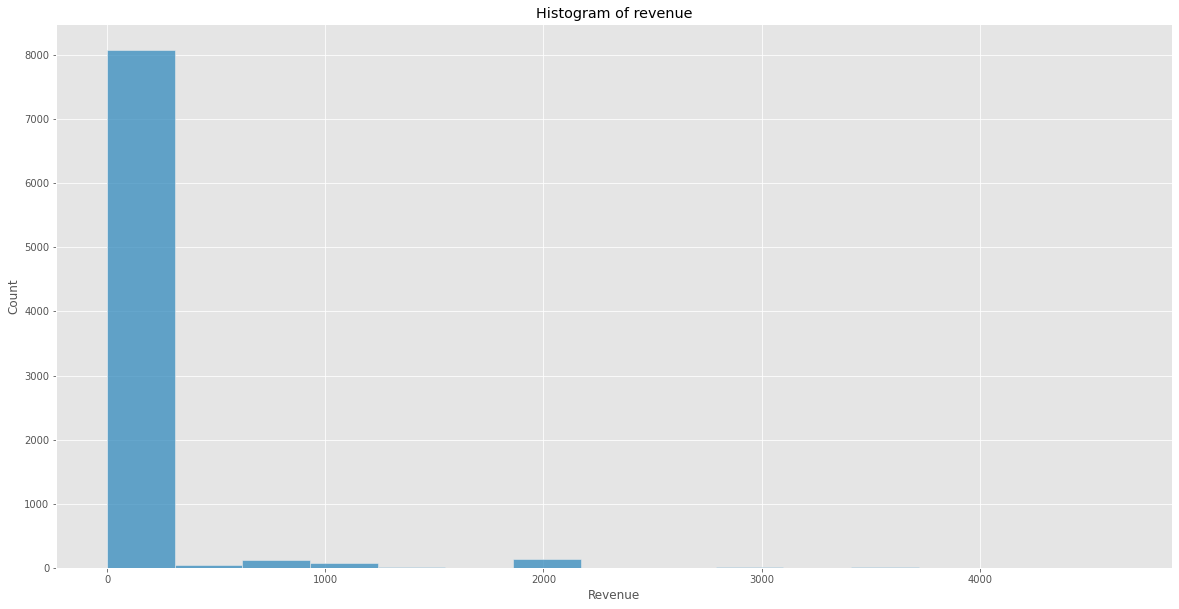

In [41]:
# построение распределения исходных данных о покупках среди активных пользователей 
plt.figure(figsize=(20, 10))
sns.histplot(x='rev', data=active_studs_all)
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title("Histogram of revenue")
plt.show()

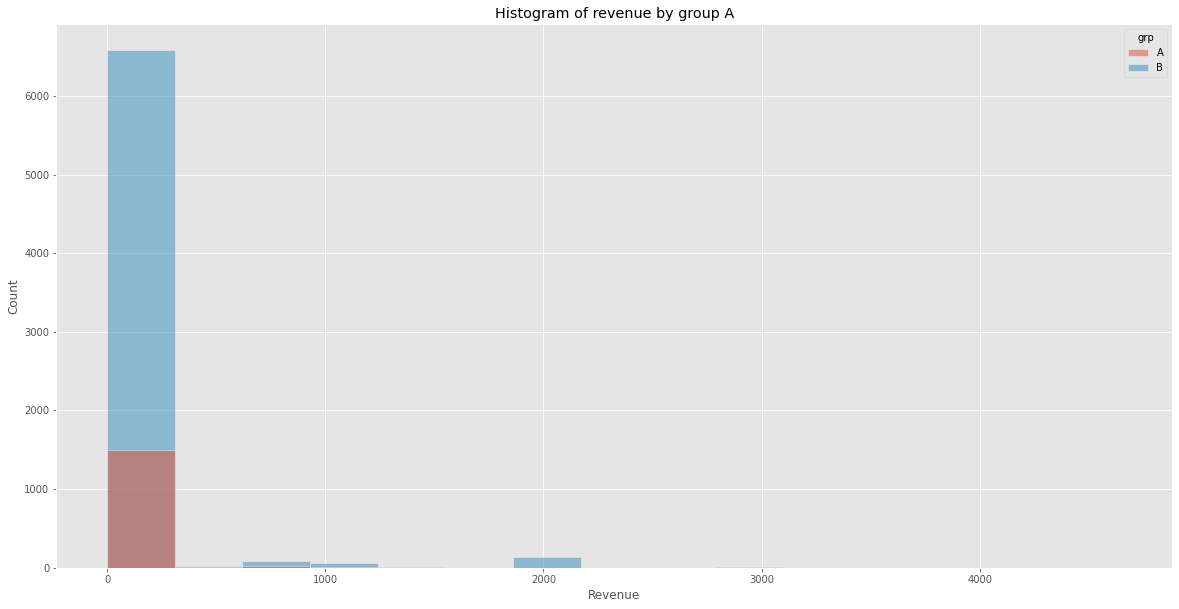

In [42]:
# построение распределения данных групп о покупках среди активных пользователей
plt.figure(figsize=(20, 10))
sns.histplot(x=active_studs_all.rev, hue=active_studs_all.grp)
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title("Histogram of revenue by group A")
plt.show()

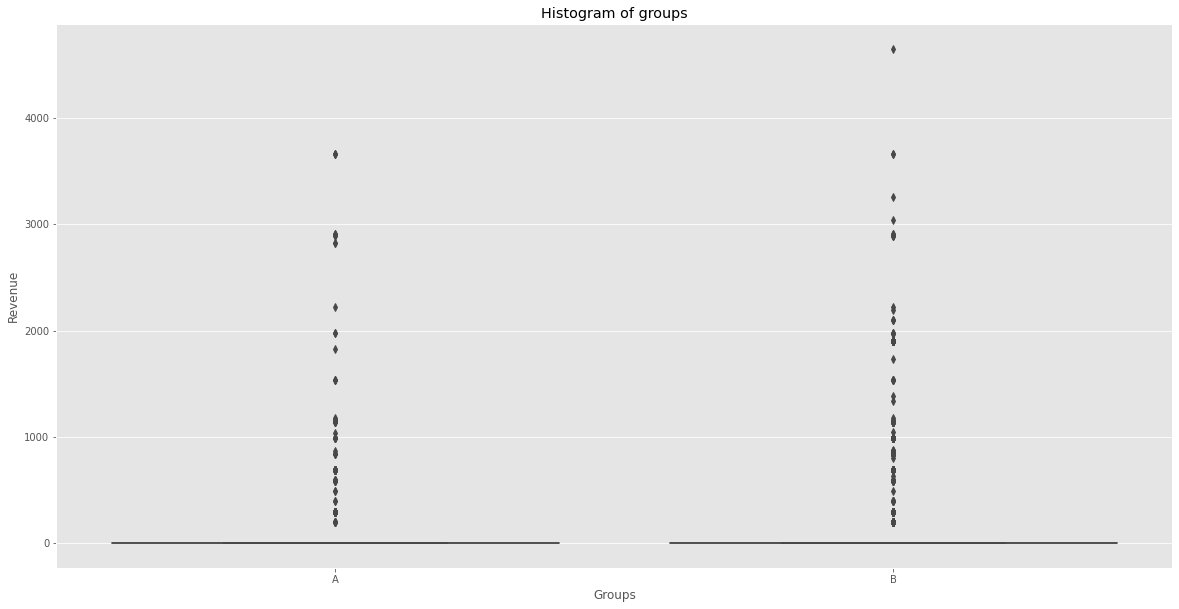

In [43]:
# график распределения прибыли по группам в виде боксплота среди активных пользователей
plt.figure(figsize=(20, 10))
sns.boxplot(x='grp', y='rev', data=active_studs_all)
plt.xlabel('Groups')
plt.ylabel('Revenue')
plt.title("Histogram of groups")
plt.show()

## Информация об распределении оплаты среди платящих пользователей           (ARPPU)

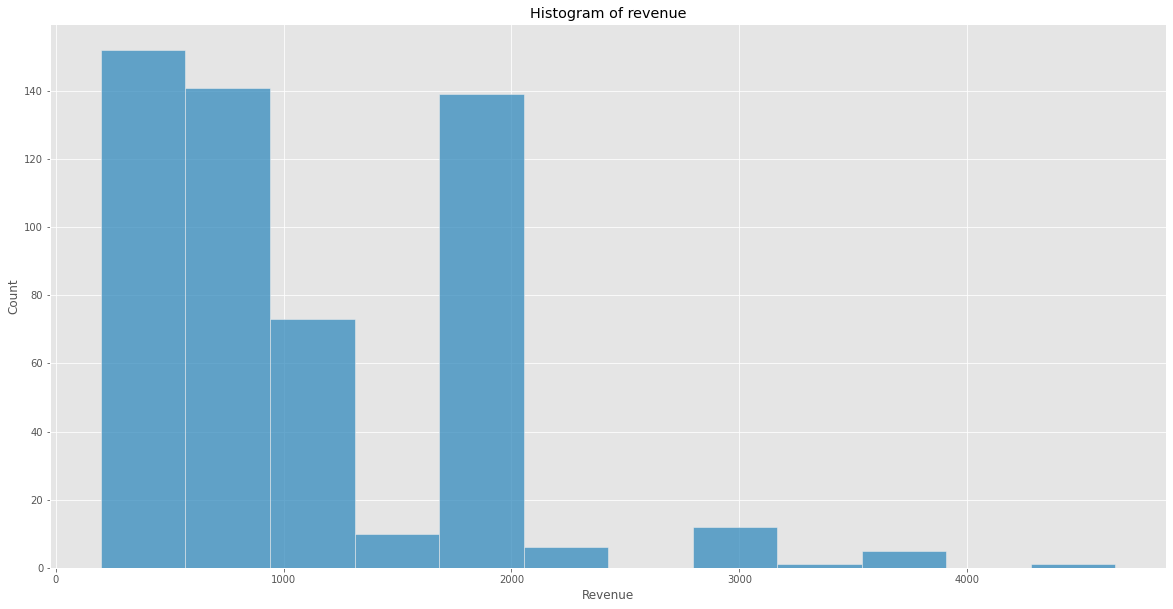

In [44]:
# построение распределения исходных данных о покупках среди покупающих пользователей
plt.figure(figsize=(20, 10))
sns.histplot(x='rev', data=checks)
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title("Histogram of revenue")
plt.show()

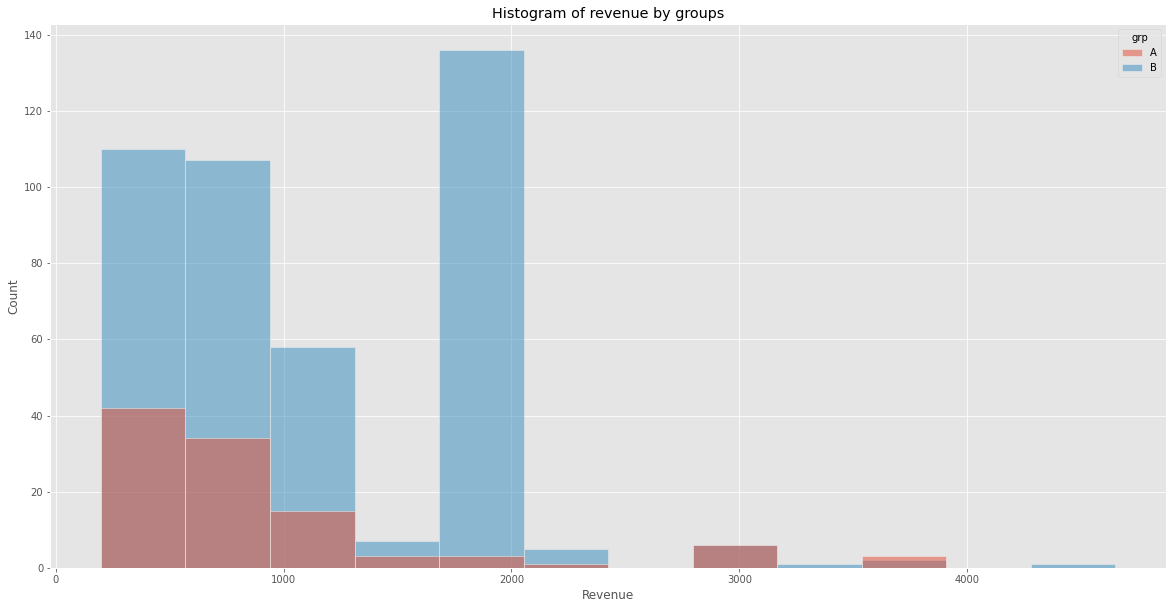

In [45]:
# построение распределения данных групп о покупках среди покупающих пользователей
plt.figure(figsize=(20, 10))
sns.histplot(x=checks.rev, hue=checks.grp)
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title("Histogram of revenue by groups")
plt.show()

In [46]:
# находим промежуток платежа, где была выявлена аномалия в целевой группе
checks[checks.grp == "B"].query('rev > 1500 and rev < 2000')

,id,rev,grp
26,264473,1900.0001,B
33,299195,1900.0000,B
34,308549,1900.0000,B
35,308594,1900.0000,B
39,330737,1900.0000,B
...,...,...,...
535,5609523,1900.0000,B
536,5645737,1900.0000,B
537,5651566,1900.0000,B
538,5662322,1900.0000,B


In [47]:
# оцениваем уникальные значения
checks[checks.grp == "B"].query('rev > 1500 and rev < 2000').rev.unique()

array([1900.0001, 1900.    , 1530.    , 1980.    , 1729.    , 1968.    ])

In [48]:
# оцениваем промежуток платежа, где была выявлена аномалия в контрольной группе
checks[checks.grp == "A"].query('rev > 1500 and rev < 2000')

,id,rev,grp
31,287008,1830.0,A
120,720651,1980.0,A
135,987129,1980.0,A
172,1184303,1530.0,A
220,1590279,1530.0,A
331,3217461,1530.0,A


In [49]:
# выведем описательные характеристики прибыли от группы А
checks[checks.grp == "A"].rev.describe()   

count     107.000000
mean      860.710280
std       815.893445
min       199.000000
25%       290.000000
50%       690.000000
75%       990.000000
max      3660.000000
Name: rev, dtype: float64

In [50]:
# выведем описательные характеристики прибыли от группы B
checks[checks.grp == "B"].rev.describe()

count     433.000000
mean     1106.997699
std       741.714026
min       199.000000
25%       398.000000
50%       880.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

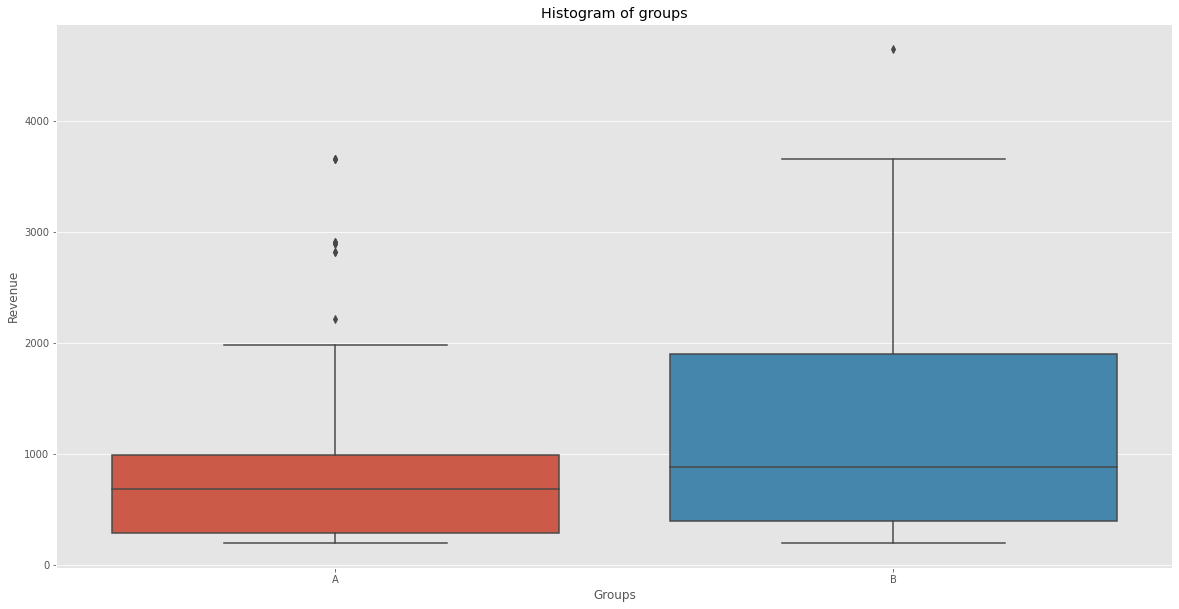

In [51]:
# график распределения прибыли по группам в виде боксплота среди покупающих пользователей
plt.figure(figsize=(20, 10))
sns.boxplot(x='grp', y='rev', data=checks)
plt.xlabel('Groups')
plt.ylabel('Revenue')
plt.title("Histogram of groups")
plt.show()

In [52]:
# расчет метрик

ARPU_a = round((checks.query('grp == "A"').rev.sum()) / (active_studs.query('grp == "A"').id.nunique()), 3)
ARPU_b = round((checks.query('grp == "B"').rev.sum()) / (active_studs.query('grp == "B"').id.nunique()), 3)
ARPPU_a = round((checks.query('grp == "A"').rev.sum()) / (checks.query('grp == "A"').id.nunique()), 3)
ARPPU_b = round((checks.query('grp == "B"').rev.sum()) / (checks.query('grp == "B"').id.nunique()), 3)

In [53]:
# добавление метрик в таблицу

metrics = pd.DataFrame({'grp': ['A', 'B'], 'ARPU': [ARPU_a, ARPU_b], 'ARPPU': [ARPPU_a, ARPPU_b]})
metrics['Paying Share'] = round((metrics.ARPU / metrics.ARPPU) * 100, 3)
metrics

,grp,ARPU,ARPPU,Paying Share
0,A,58.885,860.710,6.841
1,B,69.337,1106.998,6.264


> **Paying Share** - метрика, показывающая долю платящих пользователей. Будет использоваться в качестве проверки CR.

**Предварительные выводы по метрикам ARPU и ARPPU**, опирающиеся на графики и описательную характеристику:
-  Изменения в показателях есть (в группе B метрики ARPU и ARPPU выше) , но за счет того, что соотношение количества пользователей в группах неодинаково, то трудно говорить о значимости данных изменений.
- Имеются значительные выбросы в обоих группах.
- Медианные значения дохода с групп не сильно отличаются, по сравнению со средними значениями значениями. Такая разница обусловлена всплеском покупок в районе 1900, возможно, значельным количеством покупок какого-то конкретного курса по данной цене. Причин может быть несколько: требуется проверить независимость эксперимента (совместно с изменением механики оплаты не должен был проводиться какой-либо другой эксперимент, например по повышению покупок конкретного курса), так же возможно присутствует баг при оплате конкретных курсов, и при изменении процесса оплаты он был устранен, либо наоборот занесен (неправильное считывание данных о покупках конкретного курса).

Для определения статистической значимости изменения данных метрик, сформируем гипотезы:

>**Нулевая гипотеза** : "Результаты групп A и B на самом деле не отличаются, наблюдаемые различия случайны"
>
>**Альтернативная гипотеза** : "Результаты групп A и B статистически значимо различаются"

Так как распределение дохода в группах не является нормальным, t-тест в данном случае не применим, а результаты его непараметрического аналога критерия Манна-Уитни будут сложно интерпретируемы в данной задаче, тогда применим **бутстрап-метод** для определения статистической значимости.

Поскольку тестовая выборка имеет большие выбросы, которые искажают среднее значение, в качестве описательной статистики в бутстрап-методе выберем **медиану**, чтобы пресечь совершение ошибки первого рода.

Уровень значимости выберем 0.05 по причине соотношения досточной мощности критерия и размера выборки (больше 1000 в каждой из групп).

In [54]:
# Объявим функцию, которая проверит гипотепотезу об изменении метрик ARPU и ARPPU с помощью бутстрапа 

def get_bootstrap_ARPU_ARPPU(
    data_column_1,   # числовые значения первой выборки
    data_column_2,   # числовые значения второй выборки
    boot_it=1000,   # количество бутстрэп-подвыборок
    statistic=np.median,   # интересующая нас статистика
    bootstrap_conf_level=0.95   # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):   # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True   # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        smpl1 = samples_1
        smpl2 = samples_2
        boot_data.append(statistic((sum(smpl1) / len(smpl1)) - (sum(smpl2) / len(smpl2))))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=(20, 10))
    sns.histplot(x=pd_boot_data[0], bins=50)
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

## Применение бутстрапа для ARPU

In [55]:
active_studs_all_b = active_studs_all[active_studs_all.grp == 'B'].rev
active_studs_all_a = active_studs_all[active_studs_all.grp == 'A'].rev

In [56]:
active_studs_all_b.count()

6913

In [57]:
active_studs_all_a.count()

1564

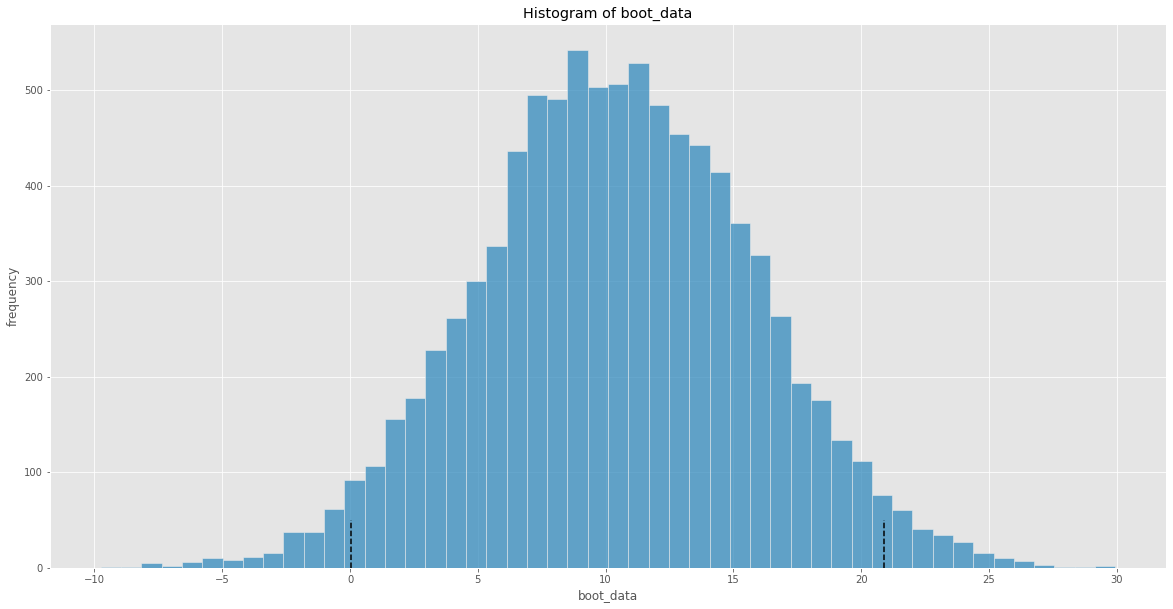

In [58]:
booted_data_ARPU = get_bootstrap_ARPU_ARPPU(active_studs_all_b, active_studs_all_a, boot_it=9000)

In [59]:
# вывод значения p уровня значимости
booted_data_ARPU["p_value"]

0.05140269099128127

In [60]:
# вывод доверительного интервала
booted_data_ARPU["ci"]

,0
0.025,0.033097
0.975,20.880479


In [61]:
# применяет критерий Манна-Уитни 
mannwhitneyu(active_studs_all_a, active_studs_all_b)

MannwhitneyuResult(statistic=5431890.0, pvalue=0.48348859422030876)

**Результат**: 
- **Бутстрап** показал p > 0,05 , 0 входит в доверительный интеграл, значит мы **принимаем нулевую гипотезу о равенстве показателя ARPU** в группах A и B.

- **Критерий Манна-Уитни** с p > 0.05 так же позволил **принять нулевую гипотезу**.

## Примерение бутстрапа к метрике ARPPU

In [62]:
checks_b = checks[checks.grp == 'B'].rev
checks_a = checks[checks.grp == 'A'].rev

In [63]:
checks_b.count()

433

In [64]:
checks_a.count()

107

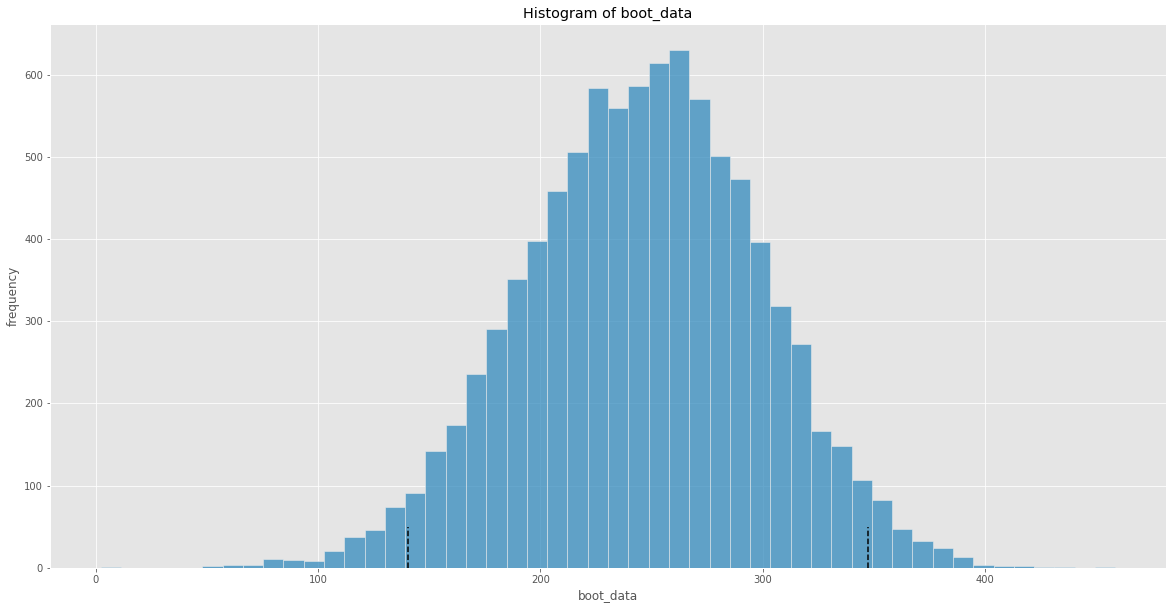

In [65]:
booted_data_ARPPU = get_bootstrap_ARPU_ARPPU(checks_b, checks_a, boot_it=9000)

In [66]:
# вывод значения p уровня значимости
booted_data_ARPPU["p_value"]

3.485591559015796e-06

In [67]:
# вывод доверительного интервала
booted_data_ARPPU["ci"]

,0
0.025,140.495619
0.975,347.568658


In [68]:
# применяет критерий Манна-Уитни 
mannwhitneyu(checks_a, checks_b)

MannwhitneyuResult(statistic=17850.0, pvalue=0.00021019690333618245)

**Результат**: 
- **Бутстрап** показал p < 0.05 , 0  не входит в доверительный интеграл, значит мы **откноняем нулевую гипотезу о равенстве показателя ARPPU** в группах A и B.

- **Критерий Манна-Уитни** с p < 0.05 так же позволил **откнонить нулевую гипотезу**.

# Анализ метрики CR 

In [69]:
# добавим колонку с критерием является ли этот пользователь покупателем или нет 
active_studs_rev = active_studs_all.rev.to_list()
buy = []
for i in active_studs_rev:
    if i == 0:
        buy.append('not_customer')
    else:
        buy.append('customer')

In [70]:
active_studs_all['buy'] = buy

In [71]:
active_studs_all

,id,grp,rev,buy
0,581585,A,0.0,not_customer
1,3276743,B,0.0,not_customer
2,4238589,A,0.0,not_customer
3,4475369,B,0.0,not_customer
4,5481015,B,0.0,not_customer
...,...,...,...,...
8472,5291900,B,199.0,customer
8473,5331842,B,290.0,customer
8474,5486319,B,199.0,customer
8475,5562806,B,398.0,customer


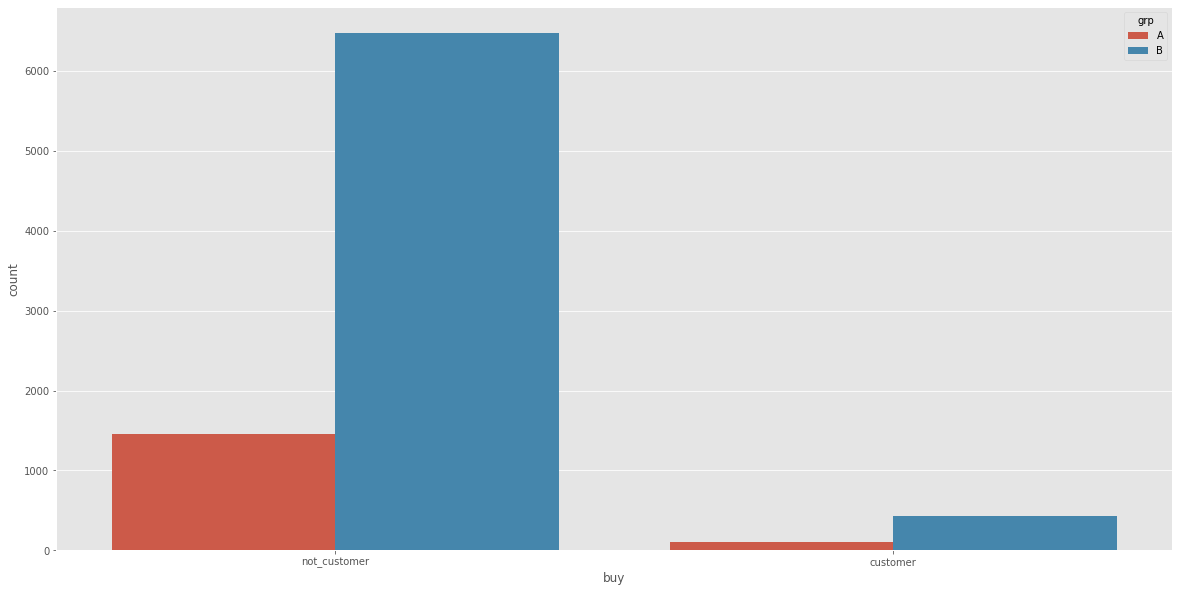

In [72]:
# график количества пользователей, которые купили/не купили курс в зависимости от группы
plt.figure(figsize=(20, 10))
sns.countplot(x="buy", hue="grp", data=active_studs_all)
plt.show()

In [73]:
active_studs_all_nan

,id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN
...,...,...,...
8472,5291900,B,199.0
8473,5331842,B,290.0
8474,5486319,B,199.0
8475,5562806,B,398.0


In [74]:
# сформируем таблицу 
cr_activ = active_studs_all_nan.groupby('grp', as_index=False)\
                               .agg({'rev': 'count', 'id': 'count'})\
                               .rename(columns={'rev': 'customer_count', 'id': 'stud_count'})

In [75]:
cr_activ['cr_activ'] = round((cr_activ.customer_count / cr_activ.stud_count) * 100, 3)

In [76]:
metrics

,grp,ARPU,ARPPU,Paying Share
0,A,58.885,860.710,6.841
1,B,69.337,1106.998,6.264


In [77]:
cr_activ

,grp,customer_count,stud_count,cr_activ
0,A,107,1564,6.841
1,B,433,6913,6.264


**Предварительные выводы по метрике CR**, опирающиеся на графики и вычисленные значения метрики:
- CR совпал с Paying Share, что говорит о корректности выполнения преобразований.
- Согласно результатам, с добавлением новой механики оплаты коэффициент сконвертировавшихся пользователей уменьшился. Это говорит о том, что новая механика оплаты на данный момент, в данных промежуток времени не дала нужного результата. Пользователи не стали чаще покупать курсы на данной образовательной платформе.

Для определения статистической значимости изменения данных метрик, сформируем гипотезы:

>**Нулевая гипотеза** : "Результаты групп A и B на самом деле не отличаются, наблюдаемые различия случайны"
>
>**Альтернативная гипотеза** : "Результаты групп A и B статистически значимо различаются"

Для проверки статистической значимости измерения метрики будем использовать **Хи-квардат**, где будут исследоваться две категориальные переменные купил/не купил и A/B группа.

In [78]:
# применим критерий Хи-квадрат
stat, p, dof, expected = chi2_contingency(pd.crosstab(active_studs_all.buy, active_studs_all.grp))

In [79]:
stat, p

(0.6204959154128902, 0.4308630604023529)

**Результат**: 
- Результат показал p > 0.05 так же позволил **принять нулевую гипотезу**.

# Итоги A/B тестирования

С учетом того, что различия между показателями ARPU и CR не статистически значимы, показатель ARPPU статистически значим, сформируем выводы:

- **Принимаем контрорльную версию A**, то только в данный промежуток времени. Чтобы принять окончательное решение по итогам эксперимента, следует отслеживать изменения в метриках. Это связано со спецификой покупки курсов, пользователь может не сразу совершить покупку, а сделать это только через время. 
- **Замечание**: стоит проверить, почему подскочил спрос на курс за 1900 в группе B.

# `Задание №2. SQL`

## В качестве СУБД будет использован ClickHouse

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень **усердным** учеником того пользователя, который хотя бы раз за текущий месяц правильно **решил 20 горошин за час**.

In [80]:
# объявляем параметры подключения
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

### `№ 2.1 Вывод информации об усердных студентах за матр 2020`

In [81]:
# написание запроса
query_count_of_students = """
SELECT
    count(correct_count) count_of_successful_students
FROM   (SELECT 
        st_id,
        timest,
        toHour(timest) as hour,
        count(correct) as correct_count,
        subject
    FROM
        (SELECT 
             toString(st_id) st_id,
             toDateTime(timest) timest,
             correct,
             toString(subject) subject
        FROM default.peas
        WHERE correct == 1 
            AND 
            (CAST(timest as date) BETWEEN '20200231' and '20200401')
        )
    GROUP BY hour, st_id, timest, subject
    )
WHERE correct_count >= 20
"""

In [82]:
# получение данных из ClickHouse
count_of_successful_students = ph.read_clickhouse(query=query_count_of_students, connection=connection_default)
count_of_successful_students = count_of_successful_students.loc[0][0]
count_of_successful_students

0

### `№ 2.2 Вывод метрик`

Образовательная платформа предлагает пройти студентам курсы по модели trial: **студент может решить бесплатно лишь 30 горошин в день**. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела **эксперимент, где был протестирован новый экран оплаты**.

In [83]:
# написание запроса
query_metrics = """
SELECT 
    test_grp,
    sum(money) / uniqExact(st_id_all) as ARPU,   
    sum(money) / uniqExact(actite_id) as ARPAU,  
    (uniqExact(st_id_buy) / uniqExact(st_id_all)) * 100 as CR,
    (uniqExact(st_id_buy) / uniqExact(actite_id)) * 100 as CR_activ,
    (uniqExact(buy_id_in_Math) / uniqExact(actite_id_in_Math)) * 100 as CR_activ_in_Math
FROM
    (
    SELECT 
        peas.st_id as st_id_all,
        check.st_id as st_id_buy,
        check.test_grp as test_grp,
        check.money as money,
        peas.actite_id as actite_id,
        peas.actite_id_in_Math as actite_id_in_Math,
        check.buy_id_in_Math as buy_id_in_Math
    FROM
        (
        SELECT 
            st_id,
            toDayOfYear(timest) as days, 
            count(correct) as count_correct, 
            CASE 
                WHEN count_correct >= 1 THEN st_id
                ELSE NULL
                END as actite_id,
            CASE 
                WHEN count_correct >= 1 AND subject == 'Math' THEN st_id
                ELSE NULL
                END as actite_id_in_Math
        FROM default.peas
        GROUP BY st_id, days, subject
        ) as peas
    LEFT JOIN 
        (
        SELECT 
            check.st_id as st_id,
            studs.test_grp as test_grp,
            sum(check.money) as money,
            CASE 
                WHEN subject == 'Math' THEN st_id
                ELSE NULL
                END as buy_id_in_Math
        FROM default.final_project_check as check
        LEFT JOIN 
            (
            SELECT *
            FROM default.studs
            ) as studs
        ON check.st_id = studs.st_id
        GROUP BY st_id, test_grp, subject
        ) as check
    ON peas.st_id = check.st_id
    ) 
GROUP BY test_grp
    
"""

In [84]:
metrics_sql = ph.read_clickhouse(query=query_metrics, connection=connection_default)
metrics_sql

,test_grp,ARPU,ARPAU,CR,CR_activ,CR_activ_in_Math
0,new,3.832586e+06,3.832586e+06,100.0,100.0,105.0
1,old,4.471207e+06,4.471207e+06,100.0,100.0,105.0


**Примечание**: интерпретация результатов в данном случае не важна, так как запросы выполнялись на учебных данных. Данное задание предназвачено для проверки написания корректности запросов.

# `Задание № 3. Python`

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [85]:
# подготовим прошлые данные: изменим название столбца и добавим столбец с датой фиксирования метрик
# данные такого формата должны поступать в функцию
metrics = metrics.rename(columns={'Paying Share': 'CR'})
metrics.insert(0, 'date', pd.to_datetime('20211229', format='%Y%m%d', errors='ignore'))

In [86]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [87]:
"""
Функция, реальзующая пересчет метрик при добавлении дополнительной информации о группах пользователей. 
Принимает на вход ссылки для скачивания данных, дату пересчета метрик и данные с прошлым расчетом метрик.
""" 


def groups_add_ab(public_key_groups_add='https://disk.yandex.ru/d/3aARY-P9pfaksg',
                  public_key_groups='https://disk.yandex.ru/d/58Us0DWOzuWAjg',
                  public_key_active_studs='https://disk.yandex.ru/d/prbgU-rZpiXVYg',
                  public_key_checks='https://disk.yandex.ru/d/84hTmELphW2sqQ',
                  date='20220101',
                  metrics_old=metrics):
    
    # получение данных из переданной ссылки с файлом на Яндекс диске
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url_groups = base_url + urlencode(dict(public_key=public_key_groups))   # формирование url 
    response_groups = requests.get(final_url_groups)   # запрос на извлечение данных по указанному url
    download_url_groups = json.loads(response_groups.text)['href']   # парсинг данных 
    groups = pd.read_csv(download_url_groups, sep=';')   # считывание данных в формате dataframe
    
    # так как названия колонок могут отличаться, а порядок нет, то вносим переименование 
    groups.columns.values[0] = 'id'
    groups.columns.values[1] = 'grp'
    
    # приведение к id и название группы к строковому типу данных
    groups = groups.astype({'id': 'string', 'grp': 'string'})

    final_url_active_studs = base_url + urlencode(dict(public_key=public_key_active_studs))
    response_active_studs = requests.get(final_url_active_studs)
    download_url_active_studs = json.loads(response_active_studs.text)['href']
    active_studs = pd.read_csv(download_url_active_studs, sep=';')
    
    # вносим переименование, так как названия колонок могут отличаться, а порядок нет
    active_studs.columns.values[0] = 'id'
    
    # приведение к id к строковому типу данных
    active_studs = active_studs.astype({'id': 'string'})

    final_url_checks = base_url + urlencode(dict(public_key=public_key_checks))
    response_checks = requests.get(final_url_checks)
    download_url_checks = json.loads(response_checks.text)['href']
    checks = pd.read_csv(download_url_checks, sep=';')
    
    # вносим переименование, так как названия колонок могут отличаться, а порядок нет
    checks.columns.values[0] = 'id'
    checks.columns.values[1] = 'rev'
    
    # приведение к id к строковому типу данных
    checks = checks.astype({'id': 'string'})
    
    final_url_groups_add = base_url + urlencode(dict(public_key=public_key_groups_add))
    response_groups_add = requests.get(final_url_groups_add)
    download_url_groups_add = json.loads(response_groups_add.text)['href']
    groups_add = pd.read_csv(download_url_groups_add, sep=',')
    
    # вносим переименование, так как названия колонок могут отличаться, а порядок нет
    groups_add.columns.values[0] = 'id'
    groups_add.columns.values[1] = 'grp'

    # приведение к id и название группы к строковому типу данных
    groups_add = groups_add.astype({'id': 'string', 'grp': 'string'})
    
    # добавление данных к основной группе
    groups_new = groups.merge(groups_add, how='outer', on=['id', 'grp'])
    
    # дополнение таблицы active_studs данными из таблицы groups
    active_studs_new_ = active_studs.merge(groups_new, how='left', on='id')
    
    # дополнение таблицы active_studs данными из таблицы groups
    checks_new = checks.merge(groups_new, how='left', on='id')
    
    # проверка на совпадение множества активных пользователей в этот день и на покупающих пользователей.
    # если запись пользователей верна, то разница будет 0, если нет, то дополняем список
    checks_new_id_list = checks_new.id.to_list()
    active_studs_new_id_list = active_studs_new.id.to_list()
    new_activ_ = list(set(checks_new_id_list) - set(active_studs_new_id_list))
    
    if len(new_activ_) != 0:
        active_studs_new_act = checks_new.query('id in @new_activ_').drop(columns=['rev'])
        # добавление нового списка id
        active_studs_new_ = active_studs_new_.merge(active_studs_new_act, how='outer', on=['id', 'grp'])
   
    # расчет метрик
    ARPU_a = round((checks_new.query('grp == "A"').rev.sum()) / (active_studs_new_.query('grp == "A"').id.nunique()), 3)
    ARPU_b = round((checks_new.query('grp == "B"').rev.sum()) / (active_studs_new_.query('grp == "B"').id.nunique()), 3)
    ARPPU_a = round((checks_new.query('grp == "A"').rev.sum()) / (checks_new.query('grp == "A"').id.nunique()), 3)
    ARPPU_b = round((checks_new.query('grp == "B"').rev.sum()) / (checks_new.query('grp == "B"').id.nunique()), 3)
    
    # добавление метрик в таблицу
    metrics_new = pd.DataFrame({'grp': ['A', 'B'], 'ARPU': [ARPU_a, ARPU_b], 'ARPPU': [ARPPU_a, ARPPU_b]})
    metrics_new['CR'] = round((metrics_new.ARPU / metrics_new.ARPPU) * 100, 3)
    
    # введем колонку, отвечающую за дату снятия метрик
    metrics_new.insert(0, 'date', pd.to_datetime(date, format='%Y%m%d', errors='ignore'))
    
    # объединение новых и старых данных
    metrics = metrics_old.merge(metrics_new, how='outer')
    
    return metrics

In [88]:
groups_add_ab()

,date,grp,ARPU,ARPPU,CR
0,2021-12-29,A,58.885,860.710,6.841
1,2021-12-29,B,69.337,1106.998,6.264
2,2022-01-01,A,59.880,860.710,6.957
3,2022-01-01,B,70.738,1108.825,6.380


In [89]:
""" 
Функция, реализующая построение графиков по изменению метрик во времени.
На вход принимается таблица значений метрик с датой их пересчета.
"""


def metrics_scheduls(metrics):
    
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    sns.lineplot(data=metrics, x="date", y="ARPU", hue="grp")
    plt.subplot(2, 2, 3)
    sns.lineplot(data=metrics, x="date", y="ARPPU", hue="grp")
    plt.subplot(1, 2, 2)
    sns.lineplot(data=metrics, x="date", y="CR", hue="grp")
    plt.show()
    
    return metrics

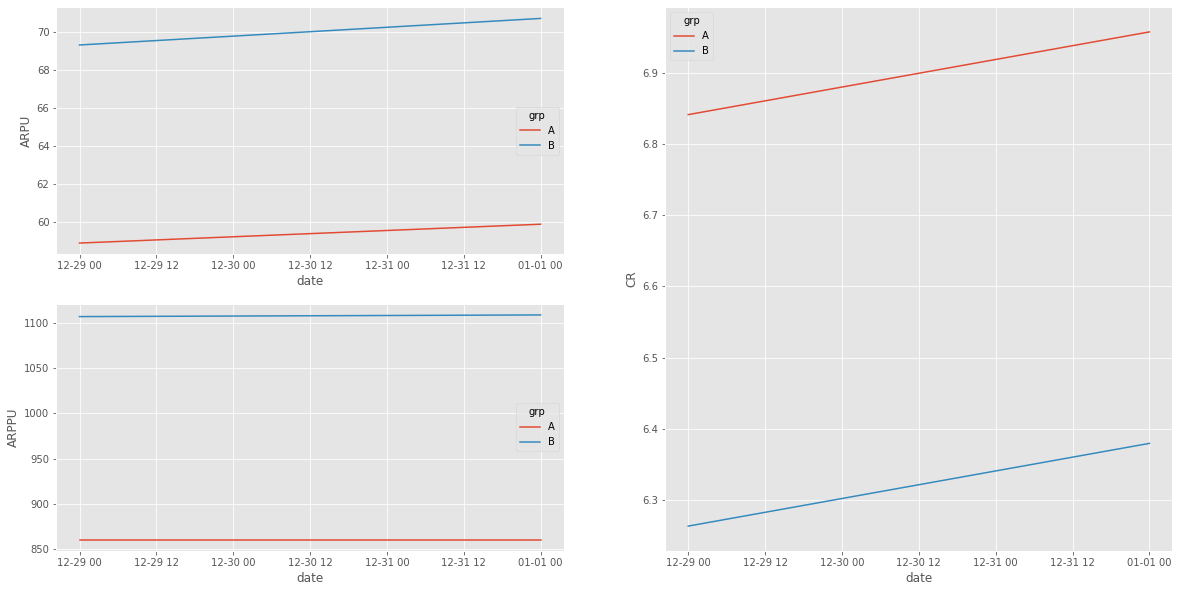

,date,grp,ARPU,ARPPU,CR
0,2021-12-29,A,58.885,860.710,6.841
1,2021-12-29,B,69.337,1106.998,6.264
2,2022-01-01,A,59.880,860.710,6.957
3,2022-01-01,B,70.738,1108.825,6.380


In [90]:
metrics_scheduls(groups_add_ab())